In [ ]:
!wget http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip

--2022-02-04 15:33:36--  http://www02.smt.ufrj.br/~offshore/mfs/database/mafaulda/imbalance.zip
Resolving www02.smt.ufrj.br (www02.smt.ufrj.br)... 146.164.99.22
Connecting to www02.smt.ufrj.br (www02.smt.ufrj.br)|146.164.99.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2212894986 (2.1G) [application/zip]
Saving to: ‘imbalance.zip’

imbalance.zip       100%[===================>]   2.06G  11.1MB/s    in 3m 26s  

2022-02-04 15:37:05 (10.3 MB/s) - ‘imbalance.zip’ saved [2212894986/2212894986]



In [ ]:
!mv /content/imbalance.zip /content/drive/MyDrive/FYP_FINAL/IBF

In [ ]:
!unzip /content/drive/MyDrive/FYP_FINAL/normal.zip
!unzip /content/drive/MyDrive/FYP_FINAL/IBF/imbalance.zip

In [ ]:
!pip install mat73
!pip install ewtpy
!pip install scaleogram

In [ ]:
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.io import loadmat
from scipy import signal
import mat73

import random
import pywt
import gc
import scaleogram as scg 

from skimage.transform import resize
from skimage import data, color
import ewtpy

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split


import keras
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.callbacks import History 

import tensorflow as tf
from tensorflow.keras.layers import Conv2D,Dense,Flatten,GlobalMaxPooling2D,MaxPooling2D,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

import itertools

from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers.recurrent import LSTM
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers import Concatenate,Average

In [ ]:
def make_confusion_matrix(y_true,y_pred,classes=None, figsize=(10,10),text_size=15):
        """
        # Note: The following confusion matrix code is a remix of Scikit-Learn's 
        # plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
        # and Made with ML's introductory notebook - https://github.com/madewithml/basics/blob/master/notebooks/09_Multilayer_Perceptrons/09_TF_Multilayer_Perceptrons.ipynb
        """
    
        cm = confusion_matrix(y_true, tf.round(y_pred))
        cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
        n_classes = cm.shape[0]

        fig, ax = plt.subplots(figsize=figsize)
        cax = ax.matshow(cm, cmap=plt.cm.Blues) # https://matplotlib.org/3.2.0/api/_as_gen/matplotlib.axes.Axes.matshow.html
        fig.colorbar(cax)

        if classes:
            labels = classes
        else:
            labels = np.arange(cm.shape[0])


        ax.set(title="Confusion Matrix",
                xlabel="Predicted label",
                ylabel="True label",
                xticks=np.arange(n_classes),
                yticks=np.arange(n_classes),
                xticklabels=labels,
                yticklabels=labels)

    
        ax.xaxis.set_label_position("bottom")
        ax.xaxis.tick_bottom()

        ax.xaxis.label.set_size(text_size)
        ax.yaxis.label.set_size(text_size)
        ax.title.set_size(text_size)

    
        threshold = (cm.max() + cm.min()) / 2.


        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                    horizontalalignment="center",
                    color="white" if cm[i, j] > threshold else "black",
                    size=text_size)

In [ ]:
cur_path = "/content/"
normal_path = glob.glob(cur_path+'/normal/*.csv',recursive=True)
imbalance_6g_path = glob.glob(cur_path+'/imbalance/6g/*.csv',recursive=True)
imbalance_10g_path = glob.glob(cur_path+'/imbalance/10g/*.csv',recursive=True)
imbalance_15g_path = glob.glob(cur_path+'/imbalance/15g/*.csv',recursive=True)
imbalance_20g_path = glob.glob(cur_path+'/imbalance/20g/*.csv',recursive=True)
imbalance_25g_path = glob.glob(cur_path+'/imbalance/25g/*.csv',recursive=True)
imbalance_30g_path = glob.glob(cur_path+'/imbalance/30g/*.csv',recursive=True)
imbalance_35g_path = glob.glob(cur_path+'/imbalance/35g/*.csv',recursive=True)
# HMA_1mm_path = glob.glob(cur_path+'/horizontal-misalignment/1.0mm/*.csv',recursive=True)

In [ ]:
columns=["Tachometer signal","ax_UBA","r_UBA","tan_UBA","ax_OBA","r_OBA","tan_OBA","mic"]

# Visualisation and Downsampling


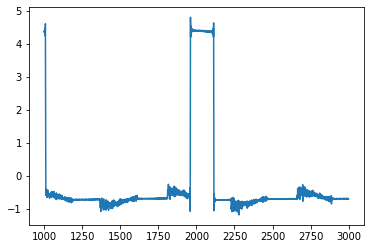

In [ ]:
pd.read_csv(normal_path[0],header=None)[1000:3000].iloc[:,0].plot();

In [ ]:
num_samples=5000
def resampler(path):
    data_n = pd.DataFrame()
    for i in path:
        _data = pd.read_csv(i,header=None).to_numpy()
        resampled_df=pd.DataFrame()
        for j in range(8):
          resample=pd.DataFrame(signal.resample(_data[:,j],num_samples))
          resampled_df=pd.concat([resampled_df,resample],axis=1,ignore_index=True)

        data_n = pd.concat([data_n,resampled_df],ignore_index=True)
    return data_n

In [ ]:
data_n = resampler(normal_path)
data_ib6g = resampler(imbalance_6g_path)
data_ib10g = resampler(imbalance_10g_path)
data_ib15g = resampler(imbalance_15g_path)
data_ib20g = resampler(imbalance_20g_path)
data_ib25g = resampler(imbalance_25g_path)
data_ib30g = resampler(imbalance_30g_path)
data_ib35g = resampler(imbalance_35g_path)

In [ ]:
data_n.shape,data_ib6g.shape

((245000, 8), (245000, 8))

In [ ]:
data_n.columns=columns
data_ib6g.columns=columns
data_ib10g.columns=columns
data_ib15g.columns=columns
data_ib20g.columns=columns
data_ib25g.columns=columns
data_ib30g.columns=columns
data_ib35g.columns=columns

In [ ]:
data_n

,Tachometer signal,ax_UBA,r_UBA,tan_UBA,ax_OBA,r_OBA,tan_OBA,mic
0,-0.850768,0.591966,-0.319066,0.082981,-0.060648,-0.000273,-0.384552,-0.004133
1,-0.574190,0.651015,-0.207690,0.048517,0.702774,0.016203,0.066414,-0.034798
2,-0.785541,-0.093521,-0.067948,-0.187593,0.114192,0.034271,-0.181514,0.033734
3,-0.331090,-0.415925,0.112794,0.023341,-0.824620,0.019790,-0.392763,0.078212
4,-0.721553,0.107008,-0.427317,-0.018937,0.576707,-0.002387,-0.144377,0.077683
...,...,...,...,...,...,...,...,...
244995,-0.632385,-0.741916,-0.312302,-0.046870,-0.235849,0.025708,-0.163253,0.086079
244996,-0.735007,0.140915,0.051428,-0.024315,-0.363787,0.028448,-0.083237,0.016953
244997,-0.529005,0.538310,0.103987,-0.038083,-0.059984,-0.034125,-0.178617,-0.033800
244998,-0.495554,-0.309957,-0.288158,0.037521,0.083001,-0.021992,-0.209230,0.035022


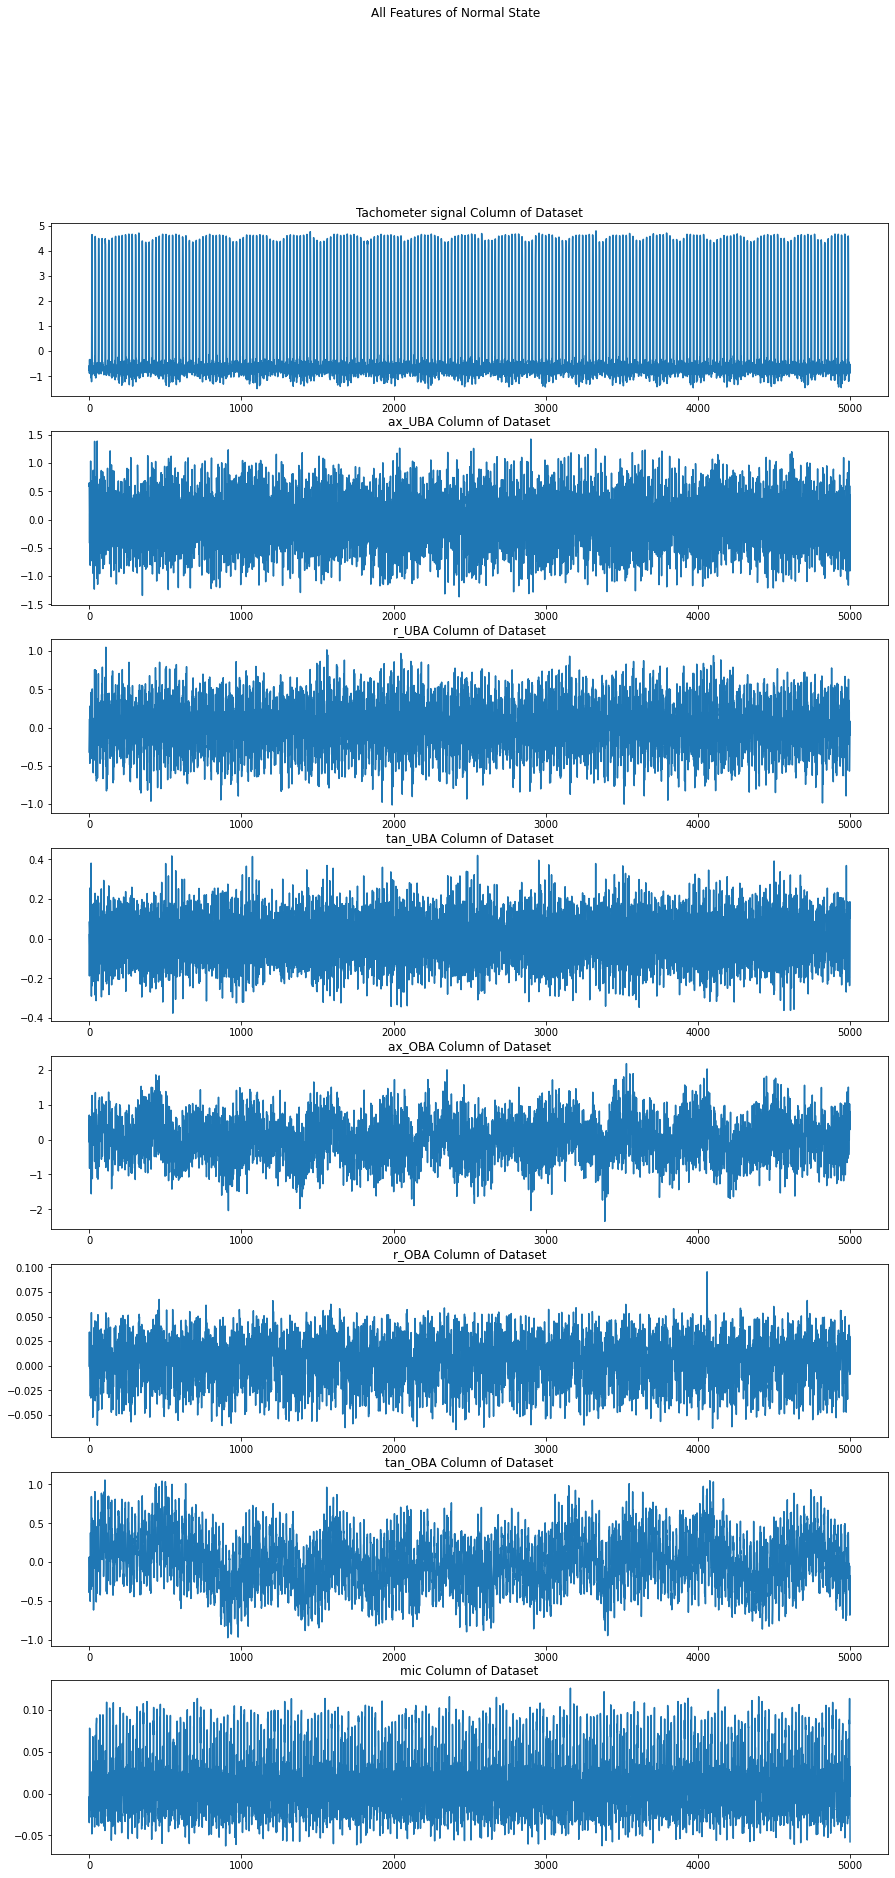

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Normal State')
for i in range(len(data_n.columns)):
    axs[i].plot(data_n[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

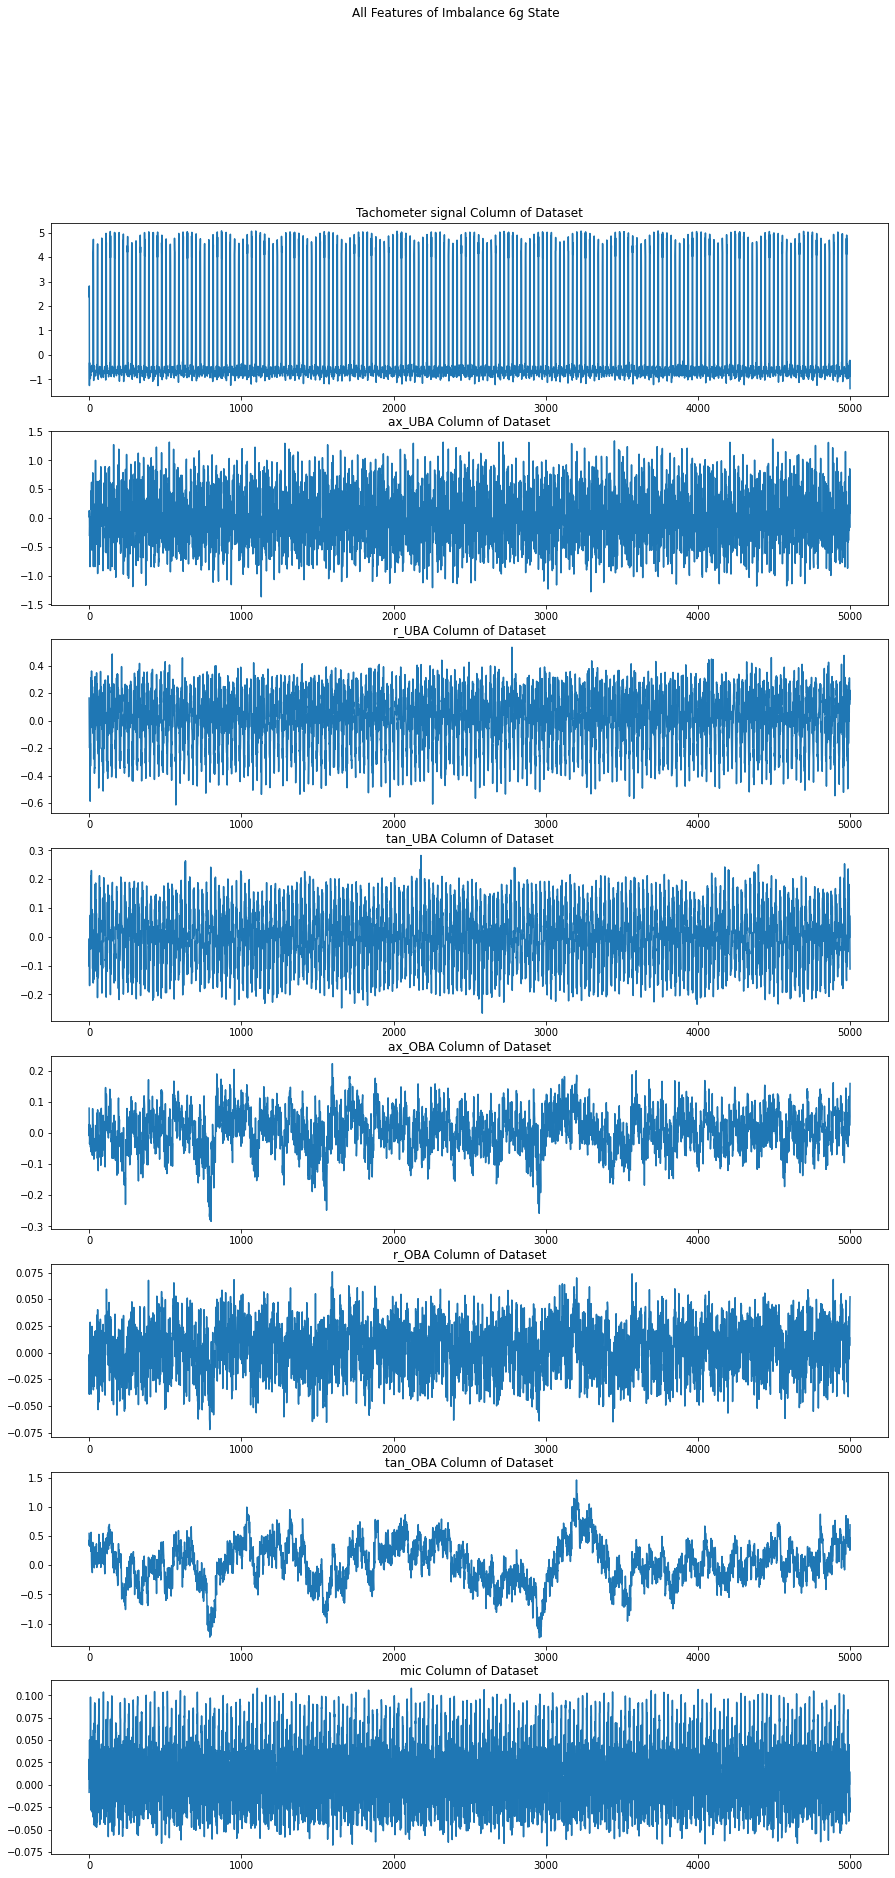

In [ ]:
fig, axs = plt.subplots(8, sharex=False, sharey=False,figsize=(15,30))
fig.suptitle('All Features of Imbalance 6g State')
for i in range(len(data_ib6g.columns)):
    axs[i].plot(data_ib6g[columns[i]][:num_samples])
    axs[i].set_title('{} Column of Dataset'.format(columns[i]))

# Data Preprocessing

In [ ]:
data_n.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245000 entries, 0 to 244999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Tachometer signal  245000 non-null  float64
 1   ax_UBA             245000 non-null  float64
 2   r_UBA              245000 non-null  float64
 3   tan_UBA            245000 non-null  float64
 4   ax_OBA             245000 non-null  float64
 5   r_OBA              245000 non-null  float64
 6   tan_OBA            245000 non-null  float64
 7   mic                245000 non-null  float64
dtypes: float64(8)
memory usage: 15.0 MB


Weight (g) Measurements

* 6 49
* 10 48
* 15 48
* 20 49
* 25 47
* 30 47
* 35 45

Total 333

Normal 49

In [ ]:
x_0=data_n.to_numpy().reshape(-1,num_samples,8)
x_1=data_ib6g.to_numpy().reshape(-1,num_samples,8)
x_2=data_ib10g.to_numpy().reshape(-1,num_samples,8)
x_3=data_ib15g.to_numpy().reshape(-1,num_samples,8)
x_4=data_ib20g.to_numpy().reshape(-1,num_samples,8)
x_5=data_ib25g.to_numpy().reshape(-1,num_samples,8)
x_6=data_ib30g.to_numpy().reshape(-1,num_samples,8)
x_7=data_ib35g.to_numpy().reshape(-1,num_samples,8)

In [ ]:
X_data=np.vstack((x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7))
X_data.shape

(382, 5000, 8)

In [ ]:
y_0 = pd.DataFrame(np.zeros(int(len(x_0)),dtype=int))
y_1 = pd.DataFrame(np.ones(int(len(x_1)),dtype=int))
y_2 = pd.DataFrame(np.full((int(len(x_2)),1),2))
y_3 = pd.DataFrame(np.full((int(len(x_3)),1),3))
y_4 = pd.DataFrame(np.full((int(len(x_4)),1),4))
y_5 = pd.DataFrame(np.full((int(len(x_5)),1),5))
y_6 = pd.DataFrame(np.full((int(len(x_6)),1),6))
y_7 = pd.DataFrame(np.full((int(len(x_7)),1),7))

y_train_data = pd.concat([y_0,y_1,y_2,y_3,y_4,y_5,y_6,y_7], ignore_index=True).to_numpy()

In [ ]:
y_train_data.shape

(382, 1)

In [ ]:
y_train_data=y_train_data.reshape(-1)

In [ ]:
y_train_data.shape

(382,)

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# train is now 75% of the entire data set
X_train, X_test, y_train, y_test = train_test_split(X_data, y_train_data, test_size=1 - train_ratio,stratify=y_train_data)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),stratify=y_test)


In [ ]:
X_train.shape,X_test.shape,X_val.shape


((267, 5000, 8), (58, 5000, 8), (57, 5000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((267,), (58,), (57,))

In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_train_rnn=np.array(np.ones((1,8)))
y_train_rnn=[]


count=0

for i in X_train:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_train_rnn=np.vstack((X_train_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_train_rnn.append(y_train[count])

  count+=1
  if count%50==0:
    print("Processed {} Train features ".format(count))
    print(X_train_rnn.shape)

Processed 50 Train features 
(1000001, 8)
Processed 100 Train features 
(2000001, 8)
Processed 150 Train features 
(3000001, 8)
Processed 200 Train features 
(4000001, 8)
Processed 250 Train features 
(5000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_test_rnn=np.array(np.ones((1,8)))
y_test_rnn=[]


count=0

for i in X_test:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_test_rnn=np.vstack((X_test_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_test_rnn.append(y_test[count])

  count+=1
  if count%50==0:
    print("Processed {} Test features ".format(count))
    print(X_test_rnn.shape)

Processed 50 Test features 
(1000001, 8)


In [ ]:
# Setting up data in terms of time data by swapping a frame over the signal
time_frame=1000 # 1 sec (for time frame of 1  sec of) ## Variable

time_interval=200 #0.2s shorter the better. But larger for easy computation ## Variable


X_val_rnn=np.array(np.ones((1,8)))
y_val_rnn=[]


count=0

for i in X_val:
  for j in range(time_frame//2,len(i)-time_frame//2,time_interval):
    X_val_rnn=np.vstack((X_val_rnn,i[j-time_frame//2:j+time_frame//2]))
    y_val_rnn.append(y_val[count])

  count+=1
  if count%50==0:
    print("Processed {} Val features ".format(count))
    print(X_val_rnn.shape)

Processed 50 Val features 
(1000001, 8)


In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((5340001, 8), (1160001, 8), (1140001, 8))

In [ ]:
X_train_rnn=X_train_rnn[1:,:].reshape(-1,time_frame,8)
X_test_rnn=X_test_rnn[1:,:].reshape(-1,time_frame,8)
X_val_rnn=X_val_rnn[1:,:].reshape(-1,time_frame,8)

In [ ]:
X_train_rnn.shape,X_test_rnn.shape,X_val_rnn.shape

((5340, 1000, 8), (1160, 1000, 8), (1140, 1000, 8))

In [ ]:
np.array(y_train_rnn).shape,np.array(y_test_rnn).shape,np.array(y_val_rnn).shape

((5340,), (1160,), (1140,))

In [ ]:
X_train=X_train_rnn
X_test=X_test_rnn
X_val=X_val_rnn

y_train=np.array(y_train_rnn)
y_test=np.array(y_test_rnn)
y_val=np.array(y_val_rnn)

In [ ]:
np.save("/content/drive/MyDrive/FYP_FINAL/IBF/X_train",X_train)
np.save("/content/drive/MyDrive/FYP_FINAL/IBF/X_test",X_test)
np.save("/content/drive/MyDrive/FYP_FINAL/IBF/X_val",X_val)

np.save("/content/drive/MyDrive/FYP_FINAL/IBF/y_train",y_train)
np.save("/content/drive/MyDrive/FYP_FINAL/IBF/y_test",y_test)
np.save("/content/drive/MyDrive/FYP_FINAL/IBF/y_val",y_val)

# Modelling

## CNN

In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_val.npy")

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((5340, 1000, 8), (1160, 1000, 8), (1140, 1000, 8))

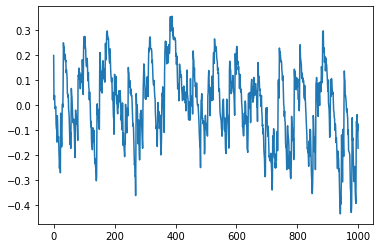

In [ ]:
i=500
j=4
signal=X_train[i,:,j]
plt.plot(signal)

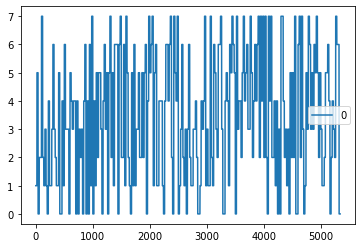

In [ ]:
pd.DataFrame(np.array(y_train)).plot();

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')

In [ ]:
num_classes=8
n_timesteps=1000
n_features=8

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
batch_size = 16
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
alpha = 0.45
model = Sequential()
model.add(Conv1D(filters=128, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha), input_shape=(n_timesteps,n_features)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation=tf.keras.layers.LeakyReLU(alpha)))
# model.add(Dropout(0.3))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.35))
model.add(Dense(64, activation=tf.keras.layers.LeakyReLU(alpha)))
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 999, 128)          2176      
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 499, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 498, 64)           16448     
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 249, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 248, 32)           4128      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 124, 32)         

In [ ]:
checkpoint=ModelCheckpoint("/content/trained_model/hma_base_CNN.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=20,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=5,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=epochs, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks)

Epoch 1/100
331/333 [============================>.] - ETA: 0s - loss: 1.3018 - accuracy: 0.4554
Epoch 1: val_loss improved from inf to 0.72186, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


333/333 [==============================] - 10s 25ms/step - loss: 1.2985 - accuracy: 0.4570 - val_loss: 0.7219 - val_accuracy: 0.7835 - lr: 0.0010
Epoch 2/100
331/333 [============================>.] - ETA: 0s - loss: 0.7874 - accuracy: 0.6778
Epoch 2: val_loss did not improve from 0.72186
333/333 [==============================] - 5s 14ms/step - loss: 0.7855 - accuracy: 0.6784 - val_loss: 0.7573 - val_accuracy: 0.6989 - lr: 0.0010
Epoch 3/100
332/333 [============================>.] - ETA: 0s - loss: 0.5931 - accuracy: 0.7660
Epoch 3: val_loss improved from 0.72186 to 0.62886, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


333/333 [==============================] - 6s 19ms/step - loss: 0.5926 - accuracy: 0.7662 - val_loss: 0.6289 - val_accuracy: 0.7614 - lr: 0.0010
Epoch 4/100
329/333 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.8181
Epoch 4: val_loss improved from 0.62886 to 0.57327, saving model to /content/trained_model/hma_base_CNN.hd5


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


333/333 [==============================] - 6s 17ms/step - loss: 0.4845 - accuracy: 0.8174 - val_loss: 0.5733 - val_accuracy: 0.8407 - lr: 0.0010
Epoch 5/100
328/333 [============================>.] - ETA: 0s - loss: 0.4466 - accuracy: 0.8350
Epoch 5: val_loss did not improve from 0.57327
333/333 [==============================] - 4s 11ms/step - loss: 0.4441 - accuracy: 0.8360 - val_loss: 0.6410 - val_accuracy: 0.8257 - lr: 0.0010
Epoch 6/100
333/333 [==============================] - ETA: 0s - loss: 0.3747 - accuracy: 0.8619
Epoch 6: val_loss did not improve from 0.57327
333/333 [==============================] - 3s 10ms/step - loss: 0.3747 - accuracy: 0.8619 - val_loss: 0.5939 - val_accuracy: 0.8195 - lr: 0.0010
Epoch 7/100
331/333 [============================>.] - ETA: 0s - loss: 0.3862 - accuracy: 0.8570
Epoch 7: val_loss did not improve from 0.57327
333/333 [==============================] - 3s 10ms/step - loss: 0.3858 - accuracy: 0.8567 - val_loss: 0.8928 - val_accuracy: 0.7702 -

INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


INFO:tensorflow:Assets written to: /content/trained_model/hma_base_CNN.hd5/assets


333/333 [==============================] - 6s 17ms/step - loss: 0.1769 - accuracy: 0.9382 - val_loss: 0.3914 - val_accuracy: 0.8812 - lr: 2.0000e-04
Epoch 11/100
328/333 [============================>.] - ETA: 0s - loss: 0.1301 - accuracy: 0.9559
Epoch 11: val_loss did not improve from 0.39144
333/333 [==============================] - 4s 11ms/step - loss: 0.1300 - accuracy: 0.9557 - val_loss: 0.4012 - val_accuracy: 0.8856 - lr: 2.0000e-04
Epoch 12/100
328/333 [============================>.] - ETA: 0s - loss: 0.1138 - accuracy: 0.9611
Epoch 12: val_loss did not improve from 0.39144
333/333 [==============================] - 3s 10ms/step - loss: 0.1142 - accuracy: 0.9609 - val_loss: 0.4077 - val_accuracy: 0.8750 - lr: 2.0000e-04
Epoch 13/100
331/333 [============================>.] - ETA: 0s - loss: 0.1032 - accuracy: 0.9673
Epoch 13: val_loss did not improve from 0.39144
333/333 [==============================] - 3s 10ms/step - loss: 0.1029 - accuracy: 0.9675 - val_loss: 0.4564 - val_

In [ ]:
class_names=["healthy","6g","10g","15g","20g","25g","30g","35g"]

In [ ]:
y_pred_probs=model.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

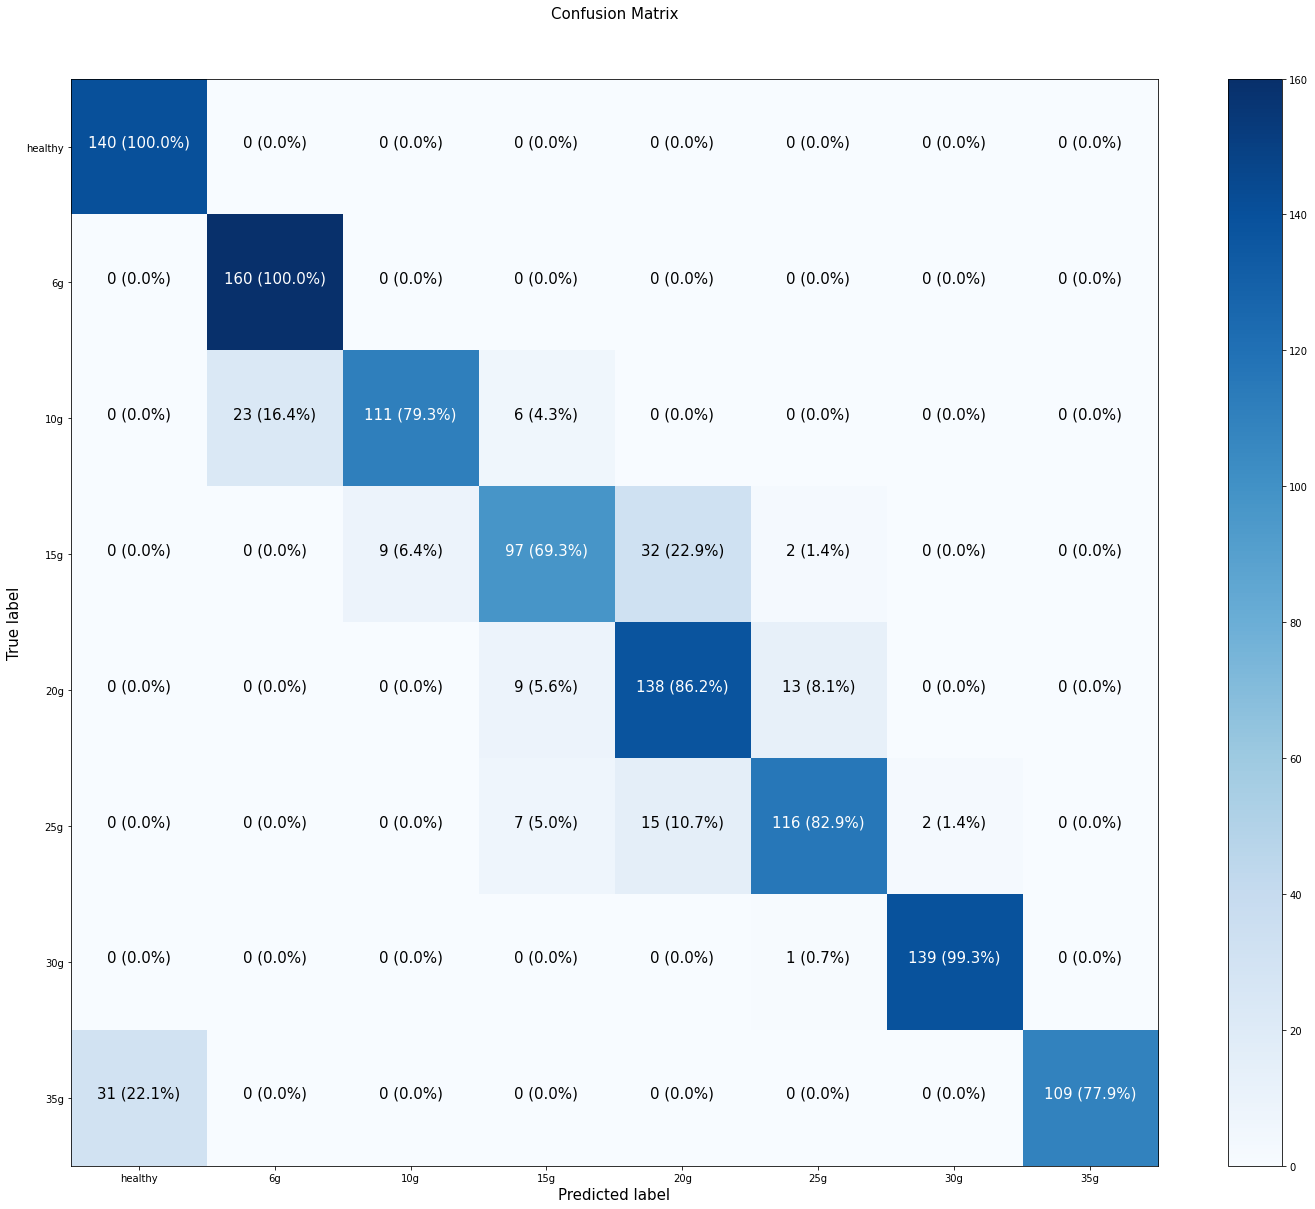

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(25,20))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

              precision    recall  f1-score   support

     healthy       0.82      1.00      0.90       140
          6g       0.87      1.00      0.93       160
         10g       0.93      0.79      0.85       140
         15g       0.82      0.69      0.75       140
         20g       0.75      0.86      0.80       160
         25g       0.88      0.83      0.85       140
         30g       0.99      0.99      0.99       140
         35g       1.00      0.78      0.88       140

    accuracy                           0.87      1160
   macro avg       0.88      0.87      0.87      1160
weighted avg       0.88      0.87      0.87      1160



In [ ]:
model.evaluate(X_test,y_test)

37/37 [==============================] - 0s 8ms/step - loss: 0.3799 - accuracy: 0.8707


[0.37988901138305664, 0.8706896305084229]

In [ ]:
!zip -r /content/drive/MyDrive/FYP_FINAL/IBF/ibf_cnn_trained_model_apr.zip /content/trained_model

updating: content/trained_model/ (stored 0%)
updating: content/trained_model/hma_base_CNN.hd5/ (stored 0%)
updating: content/trained_model/hma_base_CNN.hd5/assets/ (stored 0%)
updating: content/trained_model/hma_base_CNN.hd5/saved_model.pb (deflated 89%)
updating: content/trained_model/hma_base_CNN.hd5/variables/ (stored 0%)
updating: content/trained_model/hma_base_CNN.hd5/variables/variables.data-00000-of-00001 (deflated 8%)
updating: content/trained_model/hma_base_CNN.hd5/variables/variables.index (deflated 67%)
updating: content/trained_model/hma_base_CNN.hd5/keras_metadata.pb (deflated 92%)


## EWT + CNN


In [ ]:
X_train=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_train.npy")
X_test=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_test.npy")
X_val=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/X_val.npy")

y_train=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_val.npy")

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((5340, 1000, 8), (1160, 1000, 8), (1140, 1000, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((5340,), (1160,), (1140,))

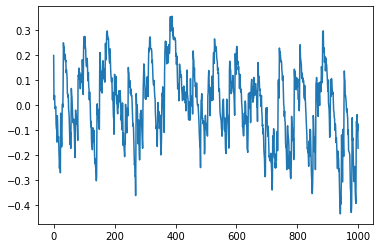

In [ ]:
i=500
j=4
signal=X_train[i,:,j]
plt.plot(signal)

In [ ]:
# Standardising and applying ewt transform
scaler=StandardScaler()
ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(signal.reshape(-1,1)).reshape(-1),N=201)

In [ ]:
ewt.shape

(1000, 201)

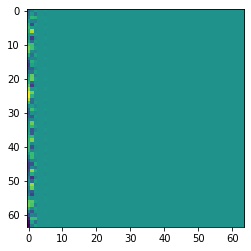

In [ ]:
plt.imshow(resize(ewt,(64,64)))

In [ ]:
train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
# Runtime is approx  6 hrs
train_data_ewt = np.ndarray(shape=(train_size, 64, 64, 8))

for i in range(0,train_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,train_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,train_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_train_data_ewt_epoch{}'.format(i),train_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_train[i,:,j].reshape(-1,1)).reshape(-1), N = 201)
        train_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Processsing 0/5340 features
Processsing 40/5340 features
Processsing 80/5340 features
Processsing 120/5340 features
Processsing 160/5340 features
Saving 199/5340 features
Processsing 200/5340 features
Processsing 240/5340 features
Processsing 280/5340 features
Processsing 320/5340 features
Processsing 360/5340 features
Saving 399/5340 features
Processsing 400/5340 features
Processsing 440/5340 features
Processsing 480/5340 features
Processsing 520/5340 features
Processsing 560/5340 features
Saving 599/5340 features
Processsing 600/5340 features
Processsing 640/5340 features
Processsing 680/5340 features
Processsing 720/5340 features
Processsing 760/5340 features
Saving 799/5340 features
Processsing 800/5340 features
Processsing 840/5340 features
Processsing 880/5340 features
Processsing 920/5340 features
Processsing 960/5340 features
Saving 999/5340 features
Processsing 1000/5340 features
Processsing 1040/5340 features
Processsing 1080/5340 features
Processsing 1120/5340 features
Proce

In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_train_data_ewt_full',train_data_ewt)

In [ ]:
# Takes 130 mins
val_data_ewt = np.ndarray(shape=(val_size, 64, 64, 8))

for i in range(0,val_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,val_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,val_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_val_data_ewt_epoch{}'.format(i),val_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_val[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        val_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Processsing 0/1140 features
Processsing 40/1140 features
Processsing 80/1140 features
Processsing 120/1140 features
Processsing 160/1140 features
Saving 199/1140 features
Processsing 200/1140 features
Processsing 240/1140 features
Processsing 280/1140 features
Processsing 320/1140 features
Processsing 360/1140 features
Saving 399/1140 features
Processsing 400/1140 features
Processsing 440/1140 features


In [ ]:
# Takes 130 mins
val_data_ewt = np.load("/content/drive/MyDrive/FYP_FINAL/IBF/ibf_val_data_ewt_epoch599.npy")

for i in range(580,val_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,val_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,val_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_val_data_ewt_epoch{}'.format(i),val_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_val[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        val_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Saving 599/1140 features
Processsing 600/1140 features
Processsing 640/1140 features
Processsing 680/1140 features
Processsing 720/1140 features
Processsing 760/1140 features
Saving 799/1140 features
Processsing 800/1140 features
Processsing 840/1140 features
Processsing 880/1140 features
Processsing 920/1140 features
Processsing 960/1140 features
Saving 999/1140 features
Processsing 1000/1140 features
Processsing 1040/1140 features
Processsing 1080/1140 features
Processsing 1120/1140 features


In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_val_data_ewt_full',val_data_ewt)

In [ ]:
# Takes 130 mins
test_data_ewt = np.ndarray(shape=(test_size, 64, 64, 8))

for i in range(0,test_size):
    if i%40 == 0:
        print("Processsing {}/{} features".format(i,test_size))
    if (i+1) % 200 == 0:
        print("Saving {}/{} features".format(i,test_size))
        np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_test_data_ewt_epoch{}'.format(i),test_data_ewt)
    for j in range(0,8):
        ewt,  _ ,_ = ewtpy.EWT1D(scaler.fit_transform(X_test[i,:,j].reshape(-1,1)).reshape(-1), N = 500)
        test_data_ewt[i, :, :, j] = resize(ewt, (64, 64))

Processsing 0/1160 features
Processsing 40/1160 features
Processsing 80/1160 features
Processsing 120/1160 features
Processsing 160/1160 features
Saving 199/1160 features
Processsing 200/1160 features
Processsing 240/1160 features
Processsing 280/1160 features
Processsing 320/1160 features
Processsing 360/1160 features
Saving 399/1160 features
Processsing 400/1160 features
Processsing 440/1160 features
Processsing 480/1160 features
Processsing 520/1160 features
Processsing 560/1160 features
Saving 599/1160 features
Processsing 600/1160 features
Processsing 640/1160 features
Processsing 680/1160 features
Processsing 720/1160 features
Processsing 760/1160 features
Saving 799/1160 features
Processsing 800/1160 features
Processsing 840/1160 features
Processsing 880/1160 features
Processsing 920/1160 features
Processsing 960/1160 features
Saving 999/1160 features
Processsing 1000/1160 features
Processsing 1040/1160 features
Processsing 1080/1160 features
Processsing 1120/1160 features


In [ ]:
np.save('/content/drive/MyDrive/FYP_FINAL/IBF/ibf_test_data_ewt_full',test_data_ewt)

### Setting correct shapes

In [ ]:
train_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/ibf_train_data_ewt_full.npy")
test_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/ibf_test_data_ewt_full.npy")
val_data_ewt=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/ibf_val_data_ewt_full.npy")

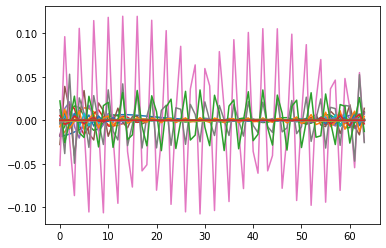

In [ ]:
plt.plot(train_data_ewt[0][:,:,0]);

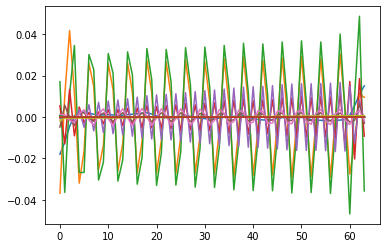

In [ ]:
plt.plot(test_data_ewt[0][:,:,0]);

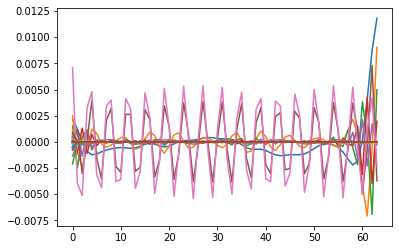

In [ ]:
plt.plot(val_data_ewt[0][:,:,0]);

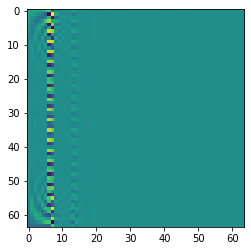

In [ ]:
plt.imshow(train_data_ewt[1][:,:,0]);

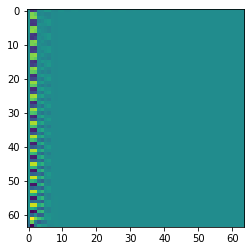

In [ ]:
plt.imshow(test_data_ewt[1][:,:,0]);

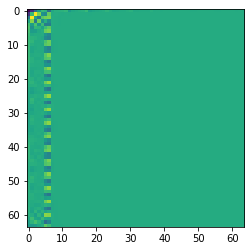

In [ ]:
plt.imshow(val_data_ewt[1][:,:,0]);

In [ ]:
y_train=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_train.npy")
y_test=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_test.npy")
y_val=np.load("/content/drive/MyDrive/FYP_FINAL/IBF/y_val.npy")

In [ ]:
np.unique(y_train,return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([680, 680, 680, 680, 680, 660, 660, 620]))

In [ ]:
y_train = list(map(lambda x: int(x), y_train))
y_test = list(map(lambda x: int(x), y_test))
y_val = list(map(lambda x: int(x),y_val))

X_train = train_data_ewt
y_train = list(y_train)
X_test = test_data_ewt
y_test = list(y_test)
X_val = val_data_ewt
y_val = list(y_val)

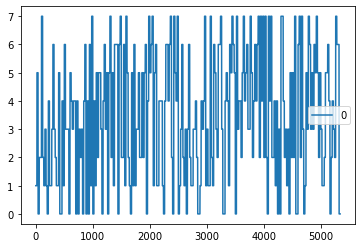

In [ ]:
pd.DataFrame(np.array(y_train)).plot()

In [ ]:
X_train,y_train=shuffle(X_train, y_train)
X_val,y_val=shuffle(X_val, y_val)
X_test,y_test=shuffle(X_val, y_val)

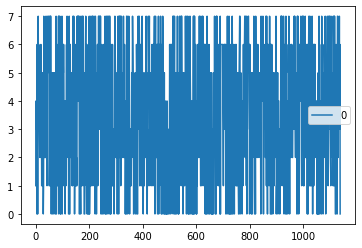

In [ ]:
pd.DataFrame(np.array(y_test)).plot();

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((5340, 64, 64, 8), (1140, 64, 64, 8), (1140, 64, 64, 8))

In [ ]:
np.array(y_train).shape, np.array(y_test).shape, np.array(y_val).shape

((5340,), (1140,), (1140,))

In [ ]:
img_x = 64
img_y = 64
img_z = 8
input_shape = (img_x, img_y, img_z)
num_classes=8
 

In [ ]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_val = X_val.astype('float32')
 

In [ ]:
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)

In [ ]:
X_train.shape,X_test.shape,X_val.shape

((5340, 64, 64, 8), (1140, 64, 64, 8), (1140, 64, 64, 8))

In [ ]:
y_train.shape,y_test.shape,y_val.shape

((5340, 8), (1140, 8), (1140, 8))

In [ ]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(2, 2), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
 
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
 


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 63, 64)        2112      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 15, 15, 64)        0

### Training

In [ ]:
batch_size = 16
epochs =100

train_size = X_train.shape[0]
val_size=X_val.shape[0]
test_size= X_test.shape[0]

In [ ]:
checkpoint=ModelCheckpoint("/content/trained_model/EWT_CNN.hd5",monitor="val_loss",mode="min",
                           save_best_only=True,verbose=1)

earlystop=EarlyStopping(monitor="val_loss",min_delta=0,patience=6,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.2,patience=2,verbose=1,min_delta=0.0001)

callbacks=[checkpoint,earlystop,reduce_lr]

In [ ]:
model.fit(X_train, y_train,steps_per_epoch=train_size//batch_size,
          batch_size=batch_size,
          epochs=epochs, validation_steps=val_size//batch_size,
          validation_data=(X_val, y_val),
          callbacks=callbacks)
 

Epoch 1/100
330/333 [============================>.] - ETA: 0s - loss: 1.7376 - accuracy: 0.2847
Epoch 1: val_loss improved from inf to 2.00646, saving model to /content/trained_model/EWT_CNN.hd5
INFO:tensorflow:Assets written to: /content/trained_model/EWT_CNN.hd5/assets
333/333 [==============================] - 25s 32ms/step - loss: 1.7362 - accuracy: 0.2857 - val_loss: 2.0065 - val_accuracy: 0.2016 - lr: 0.0010
Epoch 2/100
333/333 [==============================] - ETA: 0s - loss: 1.3082 - accuracy: 0.4491
Epoch 2: val_loss did not improve from 2.00646
333/333 [==============================] - 6s 18ms/step - loss: 1.3082 - accuracy: 0.4491 - val_loss: 2.7377 - val_accuracy: 0.0907 - lr: 0.0010
Epoch 3/100
333/333 [==============================] - ETA: 0s - loss: 1.1345 - accuracy: 0.5077
Epoch 3: val_loss did not improve from 2.00646

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
333/333 [==============================] - 6s 18ms/step - loss: 1.1345

In [ ]:
!zip -r /content/drive/MyDrive/FYP_FINAL/BRB/brb_trained_model.zip /content/trained_model

  adding: content/trained_model/ (stored 0%)
  adding: content/trained_model/EWT_CNN.hd5/ (stored 0%)
  adding: content/trained_model/EWT_CNN.hd5/keras_metadata.pb (deflated 92%)
  adding: content/trained_model/EWT_CNN.hd5/variables/ (stored 0%)
  adding: content/trained_model/EWT_CNN.hd5/variables/variables.data-00000-of-00001 (deflated 39%)
  adding: content/trained_model/EWT_CNN.hd5/variables/variables.index (deflated 69%)
  adding: content/trained_model/EWT_CNN.hd5/assets/ (stored 0%)
  adding: content/trained_model/EWT_CNN.hd5/saved_model.pb (deflated 90%)
  adding: content/trained_model/CNN.hd5/ (stored 0%)
  adding: content/trained_model/CNN.hd5/keras_metadata.pb (deflated 92%)
  adding: content/trained_model/CNN.hd5/variables/ (stored 0%)
  adding: content/trained_model/CNN.hd5/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/trained_model/CNN.hd5/variables/variables.index (deflated 66%)
  adding: content/trained_model/CNN.hd5/assets/ (stored 0%)
  addin

### Evaluation

In [ ]:
!unzip /content/drive/MyDrive/FYP_FINAL/BRB/brb_trained_model.zip 

Archive:  /content/drive/MyDrive/FYP_FINAL/BRB/brb_trained_model.zip
   creating: content/trained_model/
   creating: content/trained_model/EWT_CNN.hd5/
  inflating: content/trained_model/EWT_CNN.hd5/keras_metadata.pb  
   creating: content/trained_model/EWT_CNN.hd5/variables/
  inflating: content/trained_model/EWT_CNN.hd5/variables/variables.data-00000-of-00001  
  inflating: content/trained_model/EWT_CNN.hd5/variables/variables.index  
   creating: content/trained_model/EWT_CNN.hd5/assets/
  inflating: content/trained_model/EWT_CNN.hd5/saved_model.pb  
   creating: content/trained_model/CNN.hd5/
  inflating: content/trained_model/CNN.hd5/keras_metadata.pb  
   creating: content/trained_model/CNN.hd5/variables/
  inflating: content/trained_model/CNN.hd5/variables/variables.data-00000-of-00001  
  inflating: content/trained_model/CNN.hd5/variables/variables.index  
   creating: content/trained_model/CNN.hd5/assets/
  inflating: content/trained_model/CNN.hd5/saved_model.pb  


In [ ]:
classifier=tf.keras.models.load_model("/content/content/trained_model/EWT_CNN.hd5")

In [ ]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0

In [ ]:
class_names=["healthy","r1b","r2b","r3b","r4b"]

In [ ]:
y_pred_probs=classifier.predict(X_test)
y_true=np.argmax(y_test,axis=1)

In [ ]:
y_pred=np.argmax(y_pred_probs,axis=1)

In [ ]:
make_confusion_matrix(y_true,y_pred,classes=class_names,figsize=(20,15))

In [ ]:
print(classification_report(y_true,y_pred,target_names=class_names))

In [ ]:
model.evaluate(X_test,y_test)

18/18 [==============================] - 2s 109ms/step - loss: 0.1857 - accuracy: 0.9821


[0.18567125499248505, 0.9821428656578064]

In [ ]:
model.evaluate(X_val,y_val)

18/18 [==============================] - 2s 110ms/step - loss: 0.1857 - accuracy: 0.9821


[0.18567129969596863, 0.9821428656578064]